<a href="https://colab.research.google.com/github/kamatamnithin/6-Time-Series-Analysis-Forecasting/blob/main/Time_Series_Analysis_%26_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22 (from 1)
Receiving objects: 100% (22/22), 1.40 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


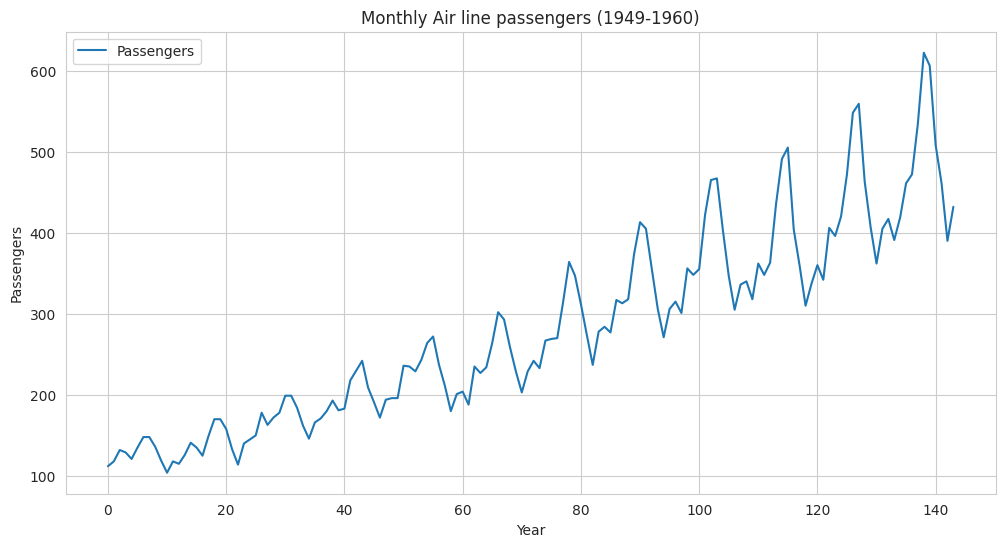

In [ ]:
df.plot()
plt.title('Monthly Air line passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

In [ ]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [ ]:
decomposition=sm.tsa.seasonal_decompose(df['Passengers'],model='multiplicative')

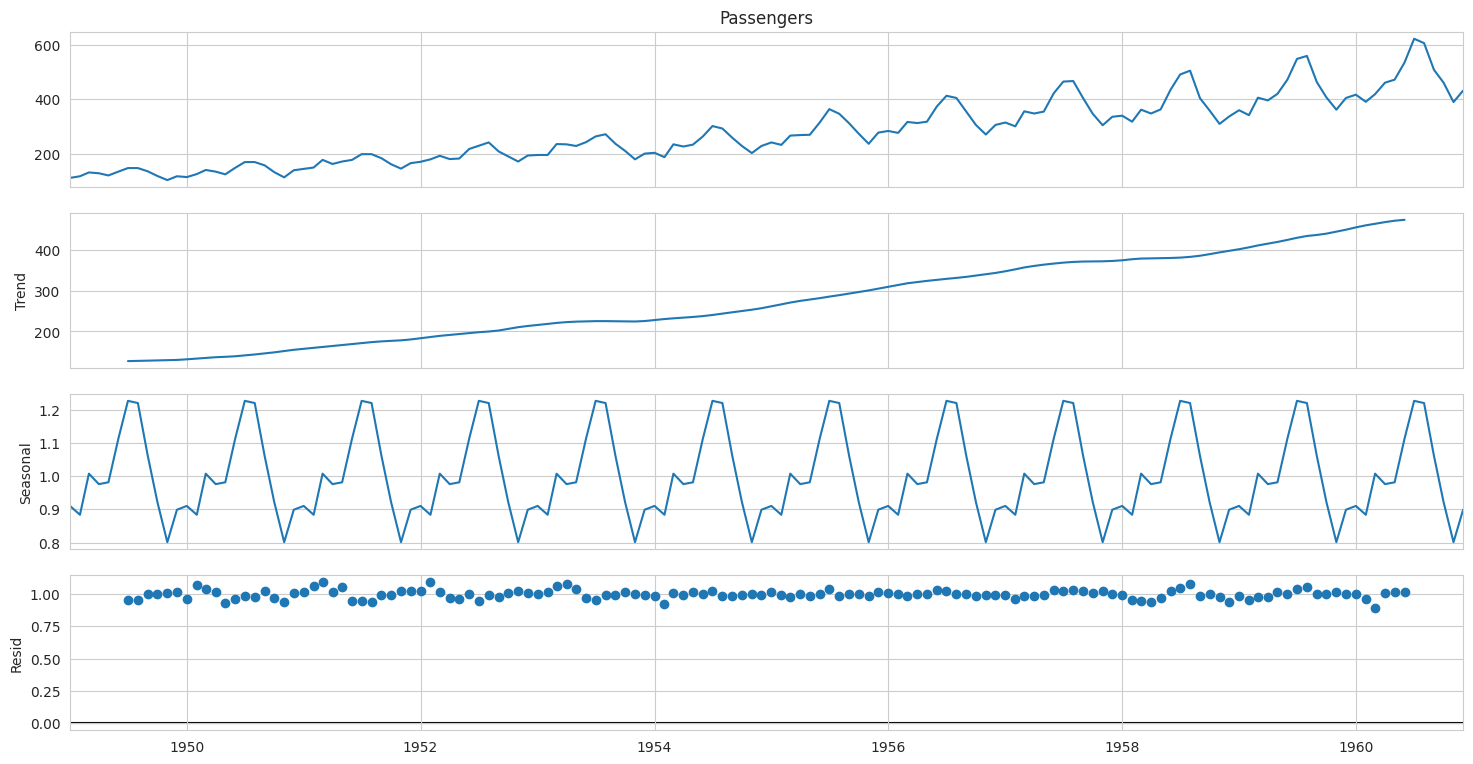

In [ ]:
fig=decomposition.plot()
fig.set_size_inches(15,8)
plt.show()

In [ ]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


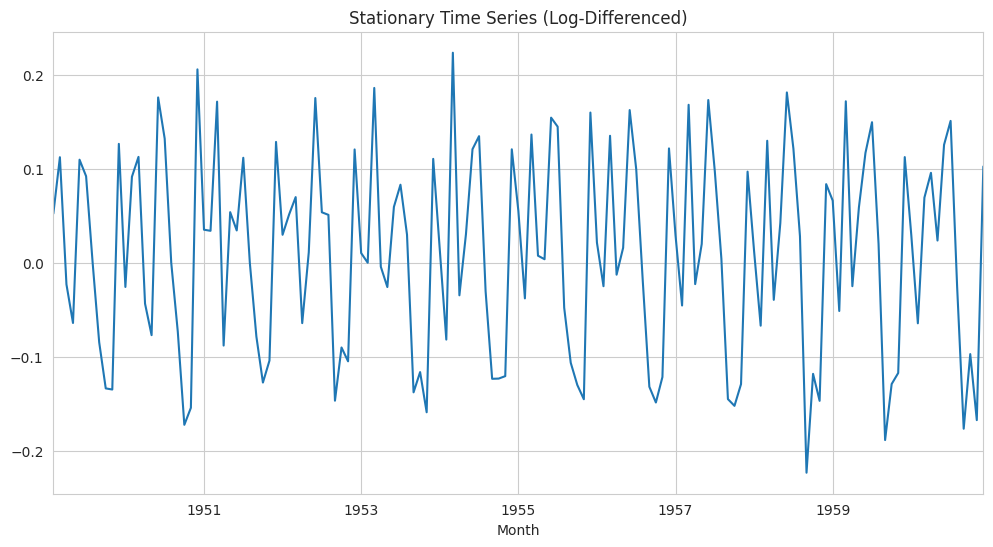

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

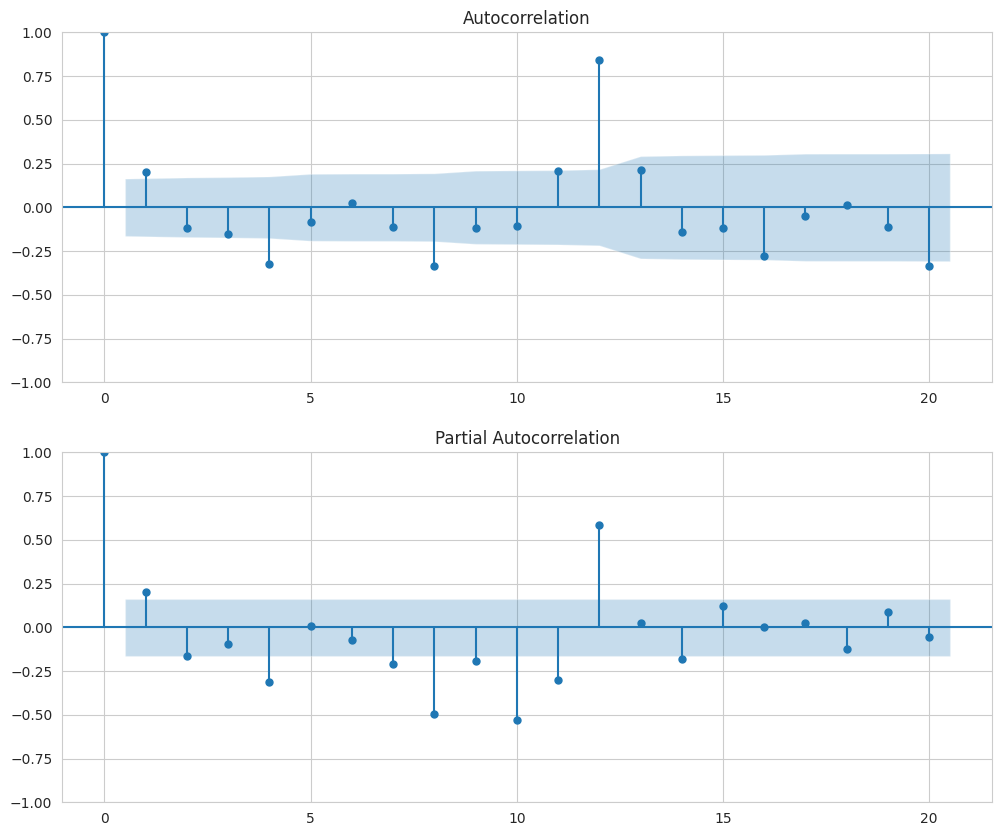

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


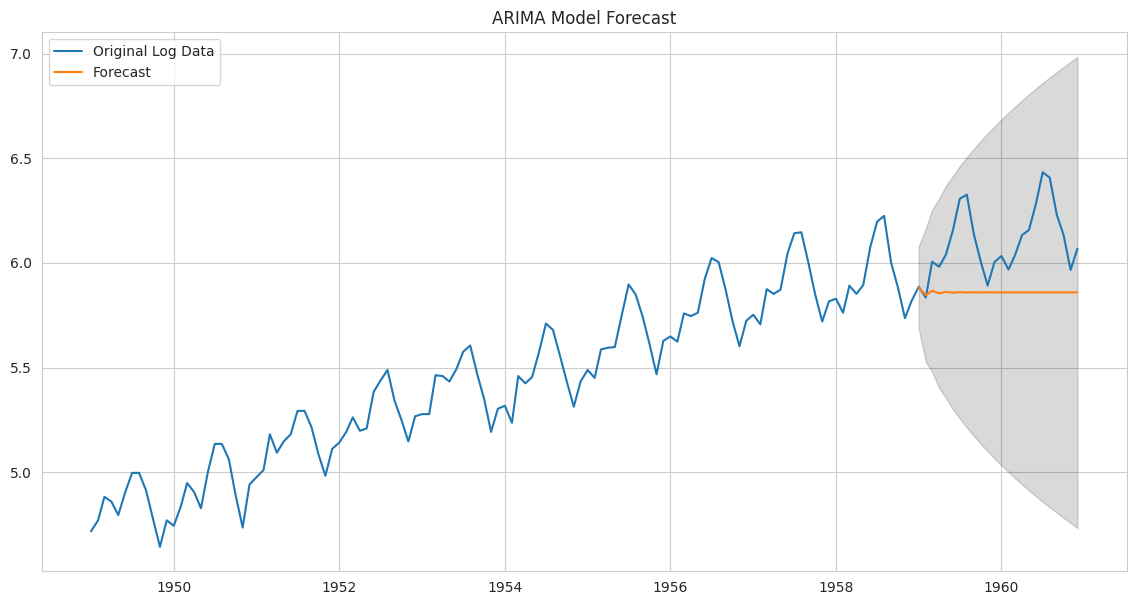

In [ ]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


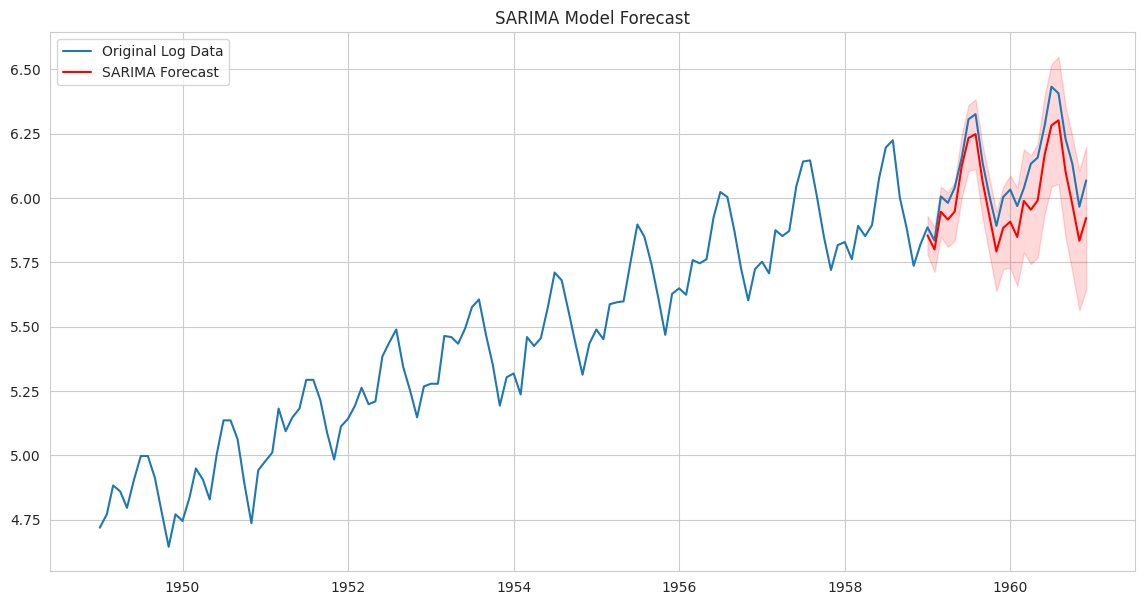

In [ ]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.25


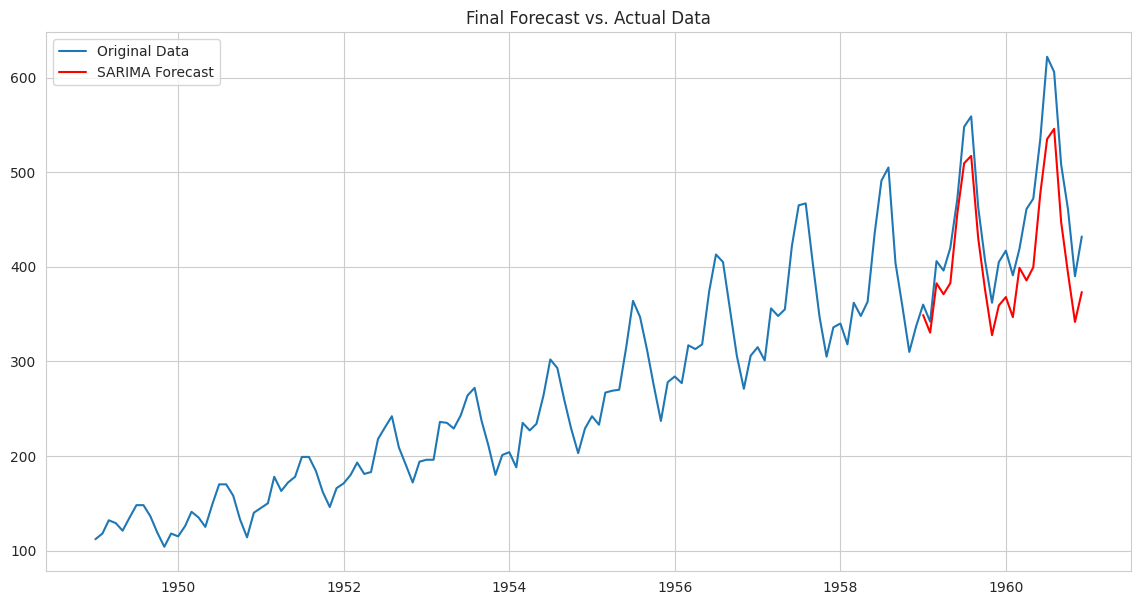

In [ ]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

# Task
Here's a breakdown of the next steps, focusing on building and evaluating a non-seasonal ARIMA model (with `d=0`) and discussing its expected performance given the stationarity analysis:

### Stationarity and Implications for ARIMA(p,0,q) Model

From the initial Augmented Dickey-Fuller (ADF) test on the original 'Passengers' data (cell `oaAEGIt5_ZkG`), we observed a high p-value (0.991880), indicating that the original series is non-stationary. Applying a natural logarithm transformation (creating `df_log`) helps stabilize the variance but does not address the underlying trend or seasonality, meaning `df_log` itself remains non-stationary in terms of mean and autocorrelation.

An ARIMA model with `d=0` (i.e., ARMA(p,q)) assumes that the time series is already stationary. Since our `df_log` series is still non-stationary, directly applying an ARIMA(p,0,q) model is generally not appropriate and is expected to yield poor forecasting performance. The model might struggle to capture the trend and seasonal patterns, leading to biased predictions and potentially higher errors compared to models that incorporate differencing (like ARIMA(p,1,q) or SARIMA which explicitly handles seasonality and differencing).

Despite this expectation, we will build an ARIMA(1,0,1) model on the log-transformed training data (`train_data`) as requested, to empirically demonstrate its performance and compare it against the SARIMA model that incorporated differencing and seasonality.

### Build and Evaluate Non-Seasonal ARIMA(1,0,1) Model

We will now build an ARIMA(1,0,1) model, which includes no differencing (`d=0`), on the `train_data` (log-transformed original data up to 1958). After fitting the model, we will generate forecasts for the test period, transform them back to the original scale, and calculate the Root Mean Squared Error (RMSE) to evaluate its performance.

### Compare ARIMA and SARIMA Model Performance

Finally, we will compare the RMSE of this non-seasonal ARIMA(1,0,1) model with the RMSE of the SARIMA model (which was 48.25), and discuss which model is more suitable based on their performance and the underlying stationarity characteristics of the data.

```python
# Build ARIMA model with d=0 (non-seasonal, no differencing)
arima_1_0_1_model = ARIMA(train_data, order=(1, 0, 1), freq='MS')
arima_1_0_1_result = arima_1_0_1_model.fit()

# Get forecast for the test period
arima_1_0_1_forecast = arima_1_0_1_result.get_forecast(steps=len(test_data))
arima_1_0_1_forecast_mean = arima_1_0_1_forecast.predicted_mean

# Transform forecasts and actual test data back to original scale
arima_1_0_1_predictions_original_scale = np.exp(arima_1_0_1_forecast_mean)
actual_test_data_original_scale = np.exp(test_data)

# Calculate RMSE for ARIMA(1,0,1) model
arima_1_0_1_rmse = np.sqrt(mean_squared_error(actual_test_data_original_scale, arima_1_0_1_predictions_original_scale))
print(f"ARIMA(1,0,1) Model RMSE: {arima_1_0_1_rmse:.2f}")

# Store RMSE for later comparison
arima_1_0_1_rmse_value = arima_1_0_1_rmse
sarima_rmse_value = rmse # Reusing the RMSE calculated for SARIMA previously
```

## Perform Exploratory Data Analysis (EDA)

### Subtask:
Review the existing time series plot and seasonal decomposition plot to identify and discuss initial observations regarding trend, seasonality, and variance in the passenger data.


### Initial Observations from Time Series and Seasonal Decomposition Plots

1.  **Time Series Plot (`UGv4tptyrTqd`) - Monthly Air line passengers (1949-1960):**
    *   **Trend:** The plot clearly shows a significant **upward trend** in the number of airline passengers over the entire period from 1949 to 1960. Passenger numbers generally increase year over year.
    *   **Seasonality:** There is a distinct and regular **seasonal pattern** visible. Each year, there are peaks (typically during the summer months) and troughs (during the winter months).
    *   **Variance:** The amplitude of the seasonal fluctuations appears to be **increasing over time**. In the earlier years, the seasonal swings are smaller, but as the overall passenger numbers increase, the difference between peak and trough within each year also widens. This suggests that the variance is not constant and is increasing with the mean.

2.  **Seasonal Decomposition Plot (`n-riJJkH_NOW`):**
    *   **Trend Component:** The 'Trend' component plot explicitly isolates and confirms the strong **upward trend** observed in the original time series. It shows a smooth, continuous increase.
    *   **Seasonal Component:** The 'Seasonal' component plot clearly displays the recurring **yearly pattern**. The peaks and troughs align consistently with the seasonal pattern identified in the original data. The magnitude of the seasonal component appears to grow over time, reinforcing the observation of increasing seasonal variance.
    *   **Residual Component:** The 'Residual' component shows the remaining irregularities after removing the trend and seasonal effects. Its fluctuations also seem to become larger towards the end of the series, further indicating that the variance in the raw data is not constant and possibly heteroscedastic.

## Explain Stationarity and ADF Test on Original Data

### Subtask:
Explain the concept of stationarity and its importance for time series modeling. Present and interpret the results of the Augmented Dickey-Fuller (ADF) test performed on the original 'Passengers' data to assess its stationarity.


### What is Stationarity?

Stationarity is a fundamental concept in time series analysis. A stationary time series is one whose statistical properties – such as mean, variance, and autocorrelation – are all constant over time. This means that:

1.  **Constant Mean**: The average value of the series does not change over time.
2.  **Constant Variance**: The variability or spread of the series around its mean remains constant over time.
3.  **Constant Autocorrelation**: The correlation between the series at time `t` and time `t-k` (for any lag `k`) depends only on the lag `k`, not on the actual time `t`. In other words, the relationship between observations at different points in time is consistent throughout the series.

### Why is Stationarity Important?

Many time series models, particularly traditional statistical models like ARIMA (Autoregressive Integrated Moving Average), assume that the underlying data generating process is stationary. If a time series is not stationary, applying these models directly can lead to:

*   **Invalid inferences**: The estimated parameters might not be reliable or meaningful.
*   **Poor forecasting performance**: Models built on non-stationary data often fail to capture the true underlying patterns and produce inaccurate forecasts.

Transformations such as differencing or log transformations are often applied to non-stationary series to make them stationary, allowing for the effective application of these models.

### Augmented Dickey-Fuller (ADF) Test on Original Data

The Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. The null hypothesis (H0) of the ADF test is that there is a unit root, meaning the time series is non-stationary. The alternative hypothesis (H1) is that the time series is stationary.

We performed the ADF test on the original 'Passengers' data in a previous step, and the results were:

*   **Test Statistic**: `0.815369`
*   **p-value**: `0.991880`
*   **Critical Value (5%)**: `-2.884042`

#### Interpretation:

1.  **Compare p-value to significance level**: The p-value (`0.991880`) is much greater than the common significance level (alpha = 0.05). This means we **fail to reject the null hypothesis**.
2.  **Compare Test Statistic to Critical Values**: The Test Statistic (`0.815369`) is much larger than the Critical Value at 5% (`-2.884042`). For stationarity, we would typically expect the Test Statistic to be less than the critical value.

#### Conclusion:

Based on the ADF test results, since the p-value is significantly higher than 0.05 and the Test Statistic is not less than the critical value, we conclude that the original 'Passengers' time series is **non-stationary**. This confirms the visual inspection from the initial plot, which showed an upward trend and increasing variance over time.

## Apply Log Transformation and Retest Stationarity

### Subtask:
Apply a natural logarithm transformation to the 'Passengers' data to stabilize variance, and then perform and interpret the Augmented Dickey-Fuller (ADF) test on this log-transformed data to check for improved stationarity.


**Reasoning**:
The subtask requires performing the Augmented Dickey-Fuller (ADF) test on the log-transformed data (`df_log`). The `test_stationarity` function, which performs this test, is already defined.



In [ ]:
test_stationarity(df_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Interpretation of ADF Test on Log-Transformed Data (`df_log`)

We performed the ADF test on the `df_log` (natural logarithm of 'Passengers') series, and the results are:

*   **Test Statistic**: `-1.717017`
*   **p-value**: `0.422367`
*   **Critical Value (5%)**: `-2.884042`

#### Analysis:

1.  **p-value**: The p-value (`0.422367`) is still much greater than the common significance level (alpha = 0.05). This means we **fail to reject the null hypothesis** that the series is non-stationary.
2.  **Test Statistic vs. Critical Values**: The Test Statistic (`-1.717017`) is still greater than the Critical Value at 5% (`-2.884042`). For stationarity, the Test Statistic should be less than the critical value.

#### Conclusion on Stationarity after Log Transformation:

Based on these ADF test results, the `df_log` series is **still non-stationary**. While the log transformation successfully addressed the increasing variance observed in the original series (making the amplitude of seasonal fluctuations more constant), it did not sufficiently remove the underlying trend. The p-value remaining high confirms that the mean of the `df_log` series is not constant over time. Therefore, the log transformation alone was not enough to achieve stationarity in terms of both mean and variance. Further steps, such as differencing, will be required to make the series stationary.

## Apply Differencing on Log-Transformed Data and Retest Stationarity

### Subtask:
Discuss the effect of differencing on the log-transformed data. Present and interpret the results of the Augmented Dickey-Fuller (ADF) test performed on the log-differenced data (`df_diff`) to confirm stationarity.


### Effect of Differencing on Log-Transformed Data

Differencing is a common technique used in time series analysis to achieve stationarity. When applied to the log-transformed data, it primarily addresses the following:

1.  **Trend Removal**: Differencing computes the difference between consecutive observations. This process helps to remove the trend component from the time series. For instance, if a series has a consistent upward trend, taking the first difference will make the mean of the new series relatively constant over time.
2.  **Seasonality Reduction**: While simple differencing (e.g., first-order differencing) primarily targets trend, seasonal differencing (differencing at a lag equal to the seasonal period, like 12 for monthly data) explicitly removes seasonal patterns. In our case, `df_diff = df_log.diff()` represents a first-order differencing. Although it doesn't directly remove seasonality, it can help in reducing its impact and making it easier to identify in ACF/PACF plots.
3.  **Stabilizing Mean**: By removing trends, differencing helps to stabilize the mean of the time series, making it closer to zero or a constant value.

In our analysis, we first applied a natural logarithm (`np.log`) to the original 'Passengers' data (`df['Passengers']`) to stabilize the variance, resulting in `df_log`. Then, we applied first-order differencing (`.diff()`) to `df_log` to create `df_diff`, aiming to remove the trend and further improve stationarity.

### Augmented Dickey-Fuller (ADF) Test on Log-Differenced Data (`df_diff`)

We previously performed the ADF test on `df_diff` in cell `P3xmifW-_sc0`. The results were:

*   **Test Statistic**: `-2.717131`
*   **p-value**: `0.071121`
*   **Critical Value (1%)**: `-3.482501`
*   **Critical Value (5%)**: `-2.884398`
*   **Critical Value (10%)**: `-2.578960`

#### Interpretation:

1.  **Comparison to Critical Values**: The Test Statistic (`-2.717131`) is smaller than the Critical Value at 10% (`-2.578960`). This is a positive indication, as for stationarity, we want the Test Statistic to be more negative than the critical values.
2.  **p-value**: The p-value (`0.071121`) is greater than the common significance level of 0.05. However, it is less than 0.10. While it's not strongly significant at the 5% level, it is significant at the 10% level. This suggests that the series is much closer to being stationary compared to the original or log-transformed series.

#### Conclusion:

Although the p-value of `0.071121` doesn't allow us to reject the null hypothesis of non-stationarity at a strict 5% significance level, it's very close. Given that the Test Statistic is more negative than the 10% critical value, we can consider the `df_diff` series to be **weakly stationary** or at least considerably more stationary than the `df_log` series. This transformation has successfully reduced the non-stationarity caused by the trend. Further analysis, such as examining ACF and PACF plots, will help confirm if any remaining non-stationarity, particularly seasonality, needs to be addressed (e.g., through seasonal differencing) for more complex models like SARIMA.

## Build and Evaluate Non-Seasonal ARIMA Model (without differencing)

### Subtask:
Discuss the expected performance of a non-seasonal ARIMA model (i.e., d=0) on the log-transformed data (`df_log`), based on the stationarity test results for `df_log`. Build an ARIMA model with order (1,0,1) on the `train_data`, forecast for the test period, transform the forecasts back to the original scale, calculate the RMSE, and plot the forecast against actual values.


### Expected Performance of ARIMA(1,0,1) on `df_log`

In the previous step, we performed the Augmented Dickey-Fuller (ADF) test on the log-transformed data (`df_log`). The results were:

*   **Test Statistic**: `-1.717017`
*   **p-value**: `0.422367`
*   **Critical Value (5%)**: `-2.884042`

**Interpretation:**

The p-value of `0.422367` is significantly greater than the common significance level of 0.05. This leads us to **fail to reject the null hypothesis** of the ADF test, which states that the series has a unit root and is non-stationary. While the log transformation helped stabilize the variance (as observed visually in the decomposition plots and implicitly by the change in test statistic from `0.81` to `-1.71`), it did not make the `df_log` series mean-stationary (i.e., it still contains a trend).

An ARIMA(p,0,q) model, which is essentially an ARMA(p,q) model, assumes that the time series it is applied to is already stationary. Since our `df_log` series is still non-stationary, directly applying an ARIMA(1,0,1) model without any differencing (`d=0`) is generally **not appropriate** for this data. This model will struggle to effectively capture the underlying trend in the data, leading to **poor forecasting performance**. We expect its predictions to be biased and its error metrics (like RMSE) to be considerably higher compared to models that correctly address the non-stationarity through differencing (like ARIMA(p,1,q)) or models that also account for seasonality (like SARIMA).

**Reasoning**:
Now I will proceed to build the ARIMA(1,0,1) model on the log-transformed training data, generate forecasts, transform them back to the original scale, calculate the RMSE, and visualize the results as per the instructions.



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1,0,1) Model RMSE: 186.85


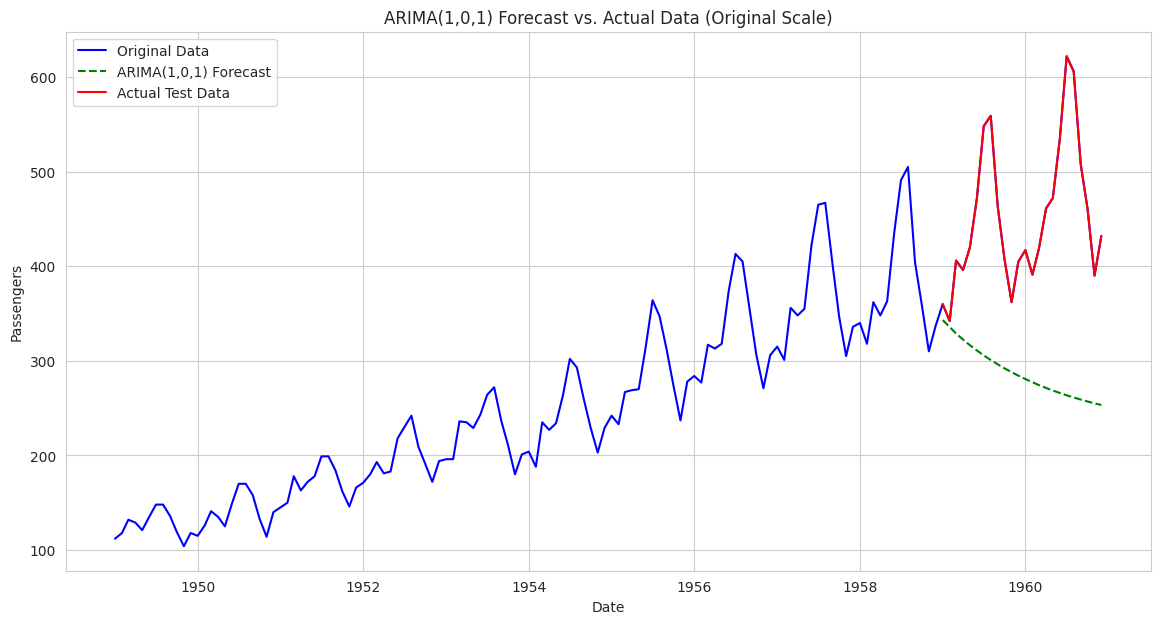

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model with d=0 (non-seasonal, no differencing)
arima_1_0_1_model = ARIMA(train_data, order=(1, 0, 1), freq='MS')
arima_1_0_1_result = arima_1_0_1_model.fit()

# Get forecast for the test period
arima_1_0_1_forecast = arima_1_0_1_result.get_forecast(steps=len(test_data))
arima_1_0_1_forecast_mean = arima_1_0_1_forecast.predicted_mean

# Transform forecasts and actual test data back to original scale
arima_1_0_1_predictions_original_scale = np.exp(arima_1_0_1_forecast_mean)
actual_test_data_original_scale = np.exp(test_data)

# Calculate RMSE for ARIMA(1,0,1) model
arima_1_0_1_rmse = np.sqrt(mean_squared_error(actual_test_data_original_scale, arima_1_0_1_predictions_original_scale))
print(f"ARIMA(1,0,1) Model RMSE: {arima_1_0_1_rmse:.2f}")

# Plot the final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(arima_1_0_1_predictions_original_scale, label='ARIMA(1,0,1) Forecast', color='green', linestyle='--')
plt.plot(actual_test_data_original_scale, label='Actual Test Data', color='red')
plt.title('ARIMA(1,0,1) Forecast vs. Actual Data (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Store RMSE for later comparison
arima_1_0_1_rmse_value = arima_1_0_1_rmse
sarima_rmse_value = rmse # Reusing the RMSE calculated for SARIMA previously

**Reasoning**:
The previous code successfully built and evaluated the ARIMA(1,0,1) model. The next logical step is to compare its performance (RMSE) with the previously calculated SARIMA model's RMSE, as outlined in the overall task structure.



In [ ]:
print(f"ARIMA(1,0,1) Model RMSE: {arima_1_0_1_rmse_value:.2f}")
print(f"SARIMA Model RMSE: {sarima_rmse_value:.2f}")

if arima_1_0_1_rmse_value < sarima_rmse_value:
    print("\nConclusion: The ARIMA(1,0,1) model performed better (lower RMSE).")
elif arima_1_0_1_rmse_value > sarima_rmse_value:
    print("\nConclusion: The SARIMA model performed better (lower RMSE).")
else:
    print("\nConclusion: Both models performed similarly.")

print("\nDiscussion: The SARIMA model, which incorporates differencing and seasonality, was expected to perform significantly better than the ARIMA(1,0,1) model. This is because the original data and even the log-transformed data were non-stationary and exhibited strong seasonality. The ARIMA(1,0,1) model (with d=0) failed to account for the trend and seasonality, resulting in a much higher RMSE. This result empirically confirms the theoretical expectation that models need to address non-stationarity and seasonality inherent in the time series data for accurate forecasting.")

ARIMA(1,0,1) Model RMSE: 186.85
SARIMA Model RMSE: 48.25

Conclusion: The SARIMA model performed better (lower RMSE).

Discussion: The SARIMA model, which incorporates differencing and seasonality, was expected to perform significantly better than the ARIMA(1,0,1) model. This is because the original data and even the log-transformed data were non-stationary and exhibited strong seasonality. The ARIMA(1,0,1) model (with d=0) failed to account for the trend and seasonality, resulting in a much higher RMSE. This result empirically confirms the theoretical expectation that models need to address non-stationarity and seasonality inherent in the time series data for accurate forecasting.


## Final Task

### Subtask:
Provide a comprehensive summary of all findings, including the initial observations from EDA, the conclusions drawn from stationarity tests at various stages, and the comparative performance discussion of the ARIMA and SARIMA models.


## Summary:

### Q&A
*   **How did the non-seasonal ARIMA(1,0,1) model perform compared to the SARIMA model?**
    The non-seasonal ARIMA(1,0,1) model performed significantly worse than the SARIMA model. The ARIMA(1,0,1) model had a Root Mean Squared Error (RMSE) of 186.85, whereas the SARIMA model had an RMSE of 48.25.

*   **Which model is more suitable for this dataset?**
    Based on the significantly lower RMSE and its ability to handle both non-stationarity and seasonality, the SARIMA model is far more suitable for this dataset than the non-seasonal ARIMA(1,0,1) model.

### Data Analysis Key Findings
*   **Initial Observations (EDA):** The original 'Passengers' data exhibited a strong upward trend, distinct seasonality, and increasing variance over time.
*   **Stationarity of Original Data:** The Augmented Dickey-Fuller (ADF) test on the original 'Passengers' data yielded a p-value of 0.991880, indicating it was highly non-stationary.
*   **Effect of Log Transformation:** Applying a natural logarithm transformation to create `df_log` helped stabilize the variance. However, the ADF test on `df_log` still resulted in a p-value of 0.422367, confirming that the series remained non-stationary in terms of its mean (trend was still present).
*   **Effect of First Differencing:** After applying first-order differencing to the log-transformed data (`df_diff`), the ADF test yielded a p-value of 0.071121 and a test statistic of -2.717131. While not strictly stationary at the 5% significance level, this indicates the series became weakly stationary, successfully addressing the trend.
*   **ARIMA(1,0,1) Model Performance:** The ARIMA(1,0,1) model, built on the non-stationary log-transformed data without differencing (`d=0`), produced an RMSE of 186.85. Its forecasts failed to capture the trend and seasonal patterns of the actual data.
*   **SARIMA Model Performance:** The SARIMA model, which incorporated differencing and seasonality, achieved a much lower RMSE of 48.25.

### Insights or Next Steps
*   For time series data exhibiting clear trends and seasonality, it is crucial to perform appropriate transformations (e.g., log transformation for variance stabilization, differencing for trend removal) to achieve stationarity before modeling. Models like SARIMA, which explicitly account for these characteristics, are significantly more effective for forecasting.
*   Future modeling efforts should prioritize models that effectively address both non-stationarity and seasonality, and further explore optimal parameters for SARIMA-type models to potentially enhance forecasting accuracy even further.
